In [136]:
import pandas as pd
import datetime
import string
from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure

import numpy as np
import matplotlib.pyplot as plt


## important: install the sample data that comes with Bokeh https://bokeh.pydata.org/en/0.10.0/docs/installation.html

In [156]:
#Infer target season 
#German Seasons
#SeasonID; Season Name; Month
#2; Spring; March, April, May
#3; Summer; June, July, August
#4; Autumn; September, October, November
#1; Winter; December, January, February
#spring = range(3, 5)
#summer = range(6, 8)
#fall = range(9, 11)
def season(month):
    if month not in range(1,12):
        return np.NaN
        #raise Exception('month must be integer value in interval [1...12] inclusive. The value of x was: {}'.format(month))
    return (month%12 + 3)//3

In [186]:
# parse the DWD dataset and convert date and align with home readings 
# Format dwd: yyyymmddhh
df = pd.read_csv('/Users/stewarta/repos/iot-htsensor/data/produkt_tu_stunde_19510101_20171231_00662.txt', sep=';')
# parse date
df.insert(2, 'datetime', pd.to_datetime(df['MESS_DATUM'], errors='coerce', format='%Y%m%d%H'))
# create index
df.set_index('datetime', inplace=True)
# extract relevant columns and rename, subset
df.rename(columns={'TT_TU':'D_Temp','RF_TU':'D_Humi'}, inplace=True)
# filter period 
filter = (df.index.year >= 2013) & (df.index.year <= 2016)
df = df[filter][['D_Temp', 'D_Humi']]
# resample day
df = df[['D_Temp', 'D_Humi']].resample('D').min()
# infer season
df['season'] = df.index.to_series().apply(lambda m : season(m.month))
df.head()                                          

,D_Temp,D_Humi,season
datetime,,,
2013-01-01,3.5,68.0,1.0
2013-01-02,3.9,76.0,1.0
2013-01-03,5.0,78.0,1.0
2013-01-04,7.9,88.0,1.0
2013-01-05,6.3,94.0,1.0


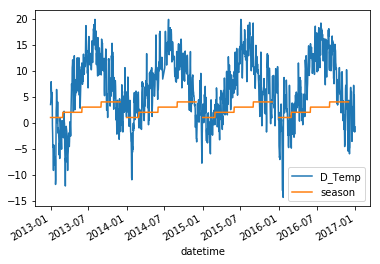

In [200]:
df[['D_Temp','season']].plot()

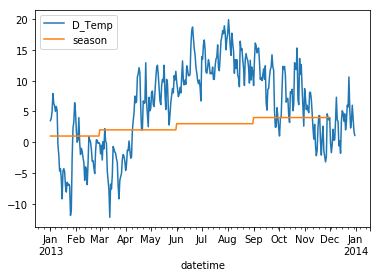

In [187]:
df[['D_Temp','season']][df.index.year == 2013].plot()

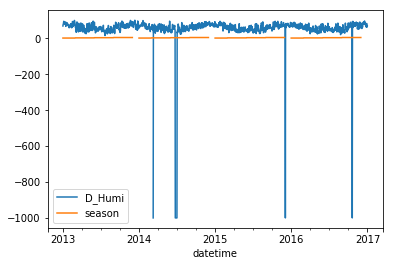

In [195]:
## HMMM: negative humidity is not okay
df[['D_Humi','season']].plot()

In [197]:
# find and drop negative outliers 
outliers = df[df.D_Humi < 0].index
df.drop(outliers, axis=0, inplace=True)

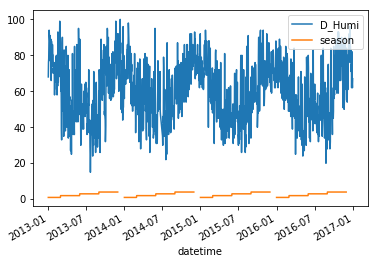

In [198]:
df[['D_Humi','season']].plot()

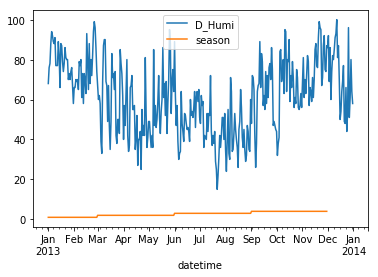

In [199]:
# zoom in on 2013
df[['D_Humi','season']][df.index.year == 2013].plot()

In [203]:

# decompose the signal
# multiplicative decompose a contrived multiplicative time series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
df.dropna(axis=0, inplace=True)
series = df.D_Temp
result = seasonal_decompose(series, model='multiplicative', freq=1)
result.plot()
pyplot.show()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [207]:
df.dropna(axis=0, inplace=True)
series = df.D_Temp

In [231]:
df.index.dayofyear

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            326, 327, 328, 329, 330, 331, 332, 333, 334, 335],
           dtype='int64', name='datetime', length=1325)

Coefficients: [ 1.56570044e-08 -1.35196650e-05  3.35779783e-03 -1.99298290e-01
  2.29612407e+00]


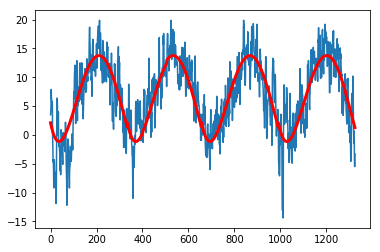

In [241]:
# model seasonality with a polynomial model
from pandas import read_csv
from matplotlib import pyplot
from numpy import polyfit
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = df.index.dayofyear
y = df.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
	value = coef[-1]
	for d in range(degree):
		value += X[i]**(degree-d) * coef[d]
	curve.append(value)
# plot curve over original data
pyplot.plot(series.values)
pyplot.plot(curve, color='red', linewidth=3)
pyplot.show()

In [233]:
df

datetime
2013-01-01     3.5
2013-01-02     3.9
2013-01-03     5.0
2013-01-04     7.9
2013-01-05     6.3
2013-01-06     5.9
2013-01-07     5.0
2013-01-08     5.8
2013-01-09     5.2
2013-01-10    -0.5
2013-01-11    -2.0
2013-01-12    -4.7
2013-01-13    -4.3
2013-01-14    -5.9
2013-01-15    -9.2
2013-01-16    -4.7
2013-01-17    -4.3
2013-01-18    -4.8
2013-01-19    -7.1
2013-01-20    -8.1
2013-01-21    -6.5
2013-01-22    -7.0
2013-01-23    -6.8
2013-01-24    -7.1
2013-01-25   -11.9
2013-01-26   -11.0
2013-01-27    -2.5
2013-01-28     2.3
2013-01-29     3.3
2013-01-30     6.4
              ... 
2016-11-01     6.7
2016-11-02     3.1
2016-11-03     0.4
2016-11-04     4.2
2016-11-05     4.2
2016-11-06     4.0
2016-11-07     2.4
2016-11-08    -1.1
2016-11-09    -1.3
2016-11-10     1.4
2016-11-11    -1.4
2016-11-12    -4.6
2016-11-13    -1.9
2016-11-14    -4.1
2016-11-15     2.4
2016-11-16     6.5
2016-11-17     7.2
2016-11-18     6.0
2016-11-19     2.7
2016-11-20     3.6
2016-11-21    10.2
201